In [63]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [64]:
# Check if GPUs are enabled for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [65]:
data_dir = './datasets/PokemonData'

In [66]:
# Set variables to reformat img heights and width and set batch size.
img_height,img_width=300,300
batch_size=32

In [67]:
# Create a training dataset with 80% of the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="int",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27260 files belonging to 150 classes.
Using 21808 files for training.


In [68]:
# Create a validation dataset with 20% of the data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27260 files belonging to 150 classes.
Using 5452 files for validation.


['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

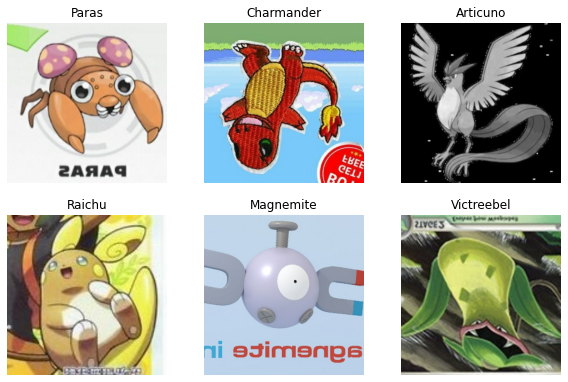

In [10]:
# View classnames and check if images are loaded properly
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
# enable multi-gpu
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


with strategy.scope():
    model = Sequential()
    # import pretrained model and output layer (where learning will take place)
    pretrained_model= tf.keras.applications.vgg19.VGG19(include_top=False,
                       input_shape=(300,300,3),
                       pooling='avg',classes=150,
                       weights='imagenet')
    for layer in pretrained_model.layers:
            layer.trainable=False

    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(150, activation='softmax'))
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 150)               76950     
                                                                 
Total params: 20,363,990
Trainable params: 339,606
N

In [70]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

2022-08-12 21:43:17.818208: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 21808
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1596"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
682/682 [==============================] - ETA: 0s - loss: 1.9301 - accuracy: 0.5698

2022-08-12 21:43:59.260966: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 5452
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1603"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



682/682 [==============================] - 53s 68ms/step - loss: 1.9301 - accuracy: 0.5698 - val_loss: 0.7803 - val_accuracy: 0.7893
Epoch 2/10
682/682 [==============================] - 45s 66ms/step - loss: 0.4940 - accuracy: 0.8643 - val_loss: 0.5463 - val_accuracy: 0.8448
Epoch 3/10
682/682 [==============================] - 45s 66ms/step - loss: 0.2484 - accuracy: 0.9299 - val_loss: 0.5092 - val_accuracy: 0.8599
Epoch 4/10
682/682 [==============================] - 45s 66ms/step - loss: 0.1634 - accuracy: 0.9521 - val_loss: 0.4306 - val_accuracy: 0.8826
Epoch 5/10
682/682 [==============================] - 46s 67ms/step - loss: 0.1641 - accuracy: 0.9502 - val_loss: 0.5379 - val_accuracy: 0.8641
Epoch 6/10
682/682 [==============================] - 44s 65ms/step - loss: 0.1541 - accuracy: 0.9529 - val_loss: 0.4678 - val_accuracy: 0.8808
Epoch 7/10
682/682 [==============================] - 46s 67ms/step - loss: 0.1301 - accuracy: 0.9597 - val_loss: 0.4690 - val_accuracy: 0.8824
Epo

In [29]:
model.save(os.path.join('./results/models','pokemonclassifierVGG19.h5'))

In [71]:
from keras.models import load_model
# inference_model = load_model('./results/models/pokemonclassifierVGG19.h5')
inference_model = model

In [72]:
# download image from the web to perform inference
pic_url = "https://www.kindpng.com/picc/m/17-176253_transparent-kabuto-png-pokemon-kabutops-mega-evolution-png.png"
with open('pic1.jpg', 'wb') as handle:
    response = requests.get(pic_url, stream=True)

    if not response.ok:
        print(response)

    for block in response.iter_content(1024):
        if not block:
            break

        handle.write(block)

In [73]:
import cv2
import pathlib
import requests
# Perform inference with training data

# inference_dir = pathlib.Path(data_dir)
# selected_pokemon = list(inference_dir.glob('Golem/*'))[0]

# Perform Inference with new data
selected_pokemon = pathlib.Path("./pic1.jpg")
PIL.Image.open(str(selected_pokemon))

image=cv2.imread(str(selected_pokemon))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

pred=inference_model.predict(image)
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

(1, 300, 300, 3)


2022-08-12 21:53:30.587929: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_271599"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2091"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

1/1 [==============================] - 2s 2s/step
The predicted class is Kabutops
